# **Overview**

For this project, I'll use a flower image dataset imported from Kaggle : [Dataset Here](https://www.kaggle.com/datasets/aksha05/flower-image-dataset/data)

Using the images in the data, I will perform EDA and build a  model that classifies the data into different flower categories. I want to use a neural network with the dropout method to assist me in creating the model.

# **Loading in Data**

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aksha05/flower-image-dataset

Dataset URL: https://www.kaggle.com/datasets/aksha05/flower-image-dataset
License(s): CC0-1.0
 86% 312M/363M [00:00<00:00, 489MB/s]
100% 363M/363M [00:00<00:00, 477MB/s]


First, I will load in the dataset from Kaggle.

In [2]:
import zipfile

zipPath = "/content/flower-image-dataset.zip"
extractPath = "/content/flowers"

with zipfile.ZipFile(zipPath, "r") as zipRef:
    zipRef.extractall(extractPath)

print("Dataset unzipped successfully to:", extractPath)

dataPath = "/content/flowers/flowers"

Dataset unzipped successfully to: /content/flowers


The data downloads in a zip file, so I need to extract the files in order to use the data. I also will set the data path.

In [15]:
import shutil
import random
import os
import tensorflow
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Next, I will import all the libaries that I'll use for my analysis and model.

# **Exploratory Data Analysis**

In [4]:
for root, dirs, files in os.walk(extractPath):
    print(f"{root} contains {len(files)} files and {len(dirs)} subfolders.")

imgFiles = [f for f in os.listdir(dataPath) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total images found: {len(imgFiles)}")
print("Example filenames:", imgFiles[:5])

/content/flowers contains 0 files and 1 subfolders.
/content/flowers/flowers contains 733 files and 0 subfolders.
Total images found: 733
Example filenames: ['garden_roses_00027.jpg', 'hibiscus_00051.jpg', 'daisies_00060.jpg', 'hibiscus_00063.jpg', 'gardenias_00015.jpg']


First, I check how many folders and files are including in the dataset. We can see that there are 733 image files, with the extension .jpg. We can also see that the flower types are categorized within the filenames, like 'hibiscus_00052.jpg'.

In [5]:
labels = [f.split('_')[0].lower() for f in imgFiles]

df = pd.DataFrame({'filename': imgFiles, 'label': labels})
df.head()

,filename,label
0,garden_roses_00027.jpg,garden
1,hibiscus_00051.jpg,hibiscus
2,daisies_00060.jpg,daisies
3,hibiscus_00063.jpg,hibiscus
4,gardenias_00015.jpg,gardenias


In order to see how many images are given per category within the dataset, I create labels based off the file names. These labels contain the name of the flower category for each image.

label
daisies          83
lilies           81
gardenias        77
peonies          75
hibiscus         74
garden           74
bougainvillea    74
tulip            71
orchids          64
hydrangeas       60
Name: count, dtype: int64


/tmp/ipython-input-3905564709.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = categoryCnts.index, y = categoryCnts.values, palette = "flare")


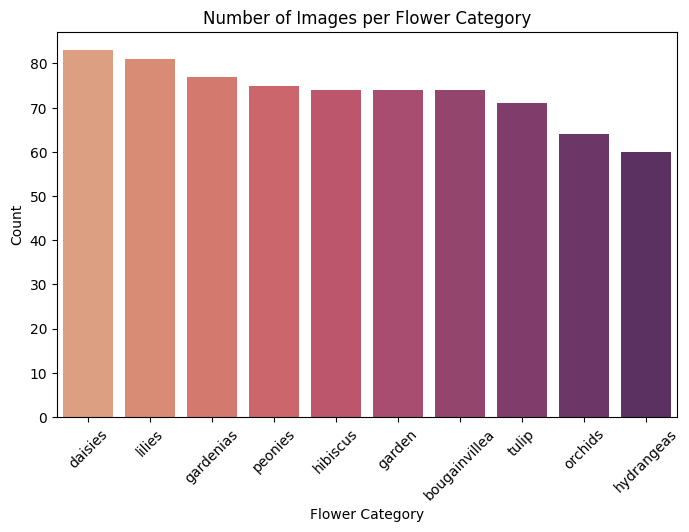

In [6]:
categoryCnts = df['label'].value_counts()

print(categoryCnts)
plt.figure(figsize = (8,5))
sns.barplot(x = categoryCnts.index, y = categoryCnts.values, palette = "flare")
plt.title("Number of Images per Flower Category")
plt.xlabel("Flower Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Next, I see how many images are provided in the dataset for each classification of flower. There are a total of 10 flower classifications. First, we can see that the image counts are not even, so each cateogry has a varying amount of images. Daises have the most images at 84, whereas hydrangeas have the lowest images at 60. This will be something to consider when creating the model.

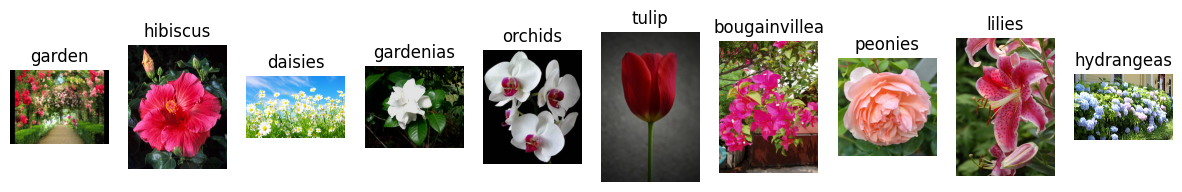

In [7]:
uniqueLabels = df['label'].unique()
plt.figure(figsize = (15, 6))

for i, label in enumerate(uniqueLabels):
    sample_file = random.choice(df[df['label'] == label]['filename'].values)
    img_path = os.path.join(dataPath, sample_file)
    img = Image.open(img_path)

    plt.subplot(1, len(uniqueLabels), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.show()

Then, I print an example image from each classification. From the information gathered so far, we can start working towards building a classification model.

# **Classification Model**

In [8]:
trainData, testData = train_test_split(df, test_size = 0.2, random_state = 42)

print("Train samples:", len(trainData))
print("Test samples:", len(testData))

Train samples: 586
Test samples: 147


I first split the data into an 80/20 train/test ratio.

In [9]:
trainData_Generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)

testData_Generator = ImageDataGenerator(rescale = 1./255)

trainData_General = trainData_Generator.flow_from_dataframe(
    trainData,
    directory = dataPath,
    x_col = 'filename',
    y_col = 'label',
    target_size = (180, 180),
    batch_size = 32,
    class_mode = 'categorical'
)

testData_General = testData_Generator.flow_from_dataframe(
    testData,
    directory = dataPath,
    x_col = 'filename',
    y_col = 'label',
    target_size = (180, 180),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 586 validated image filenames belonging to 10 classes.
Found 147 validated image filenames belonging to 10 classes.


I take some data augmentation steps to help increase the diversity of my dataset and help the model predict better. For example, the data is flipped or resized.

In [10]:
numClasses = len(trainData_General.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (180, 180, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.5),

    layers.Dense(numClasses, activation = 'softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,203,274 (50.37 MB)

 Trainable params: 13,203,274 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

For the model itself, I will be using a Convolutional Neural Network (CNN) and pair it with the dropout method. Since the dataset is relatively small, I have slight doubts about how well a neural network will perform. However, I will test it out!

In [11]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    trainData_General,
    validation_data = testData_General,
    epochs = 20
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.1356 - loss: 2.9247 - val_accuracy: 0.1429 - val_loss: 2.2491
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.1698 - loss: 2.1709 - val_accuracy: 0.2517 - val_loss: 1.9987
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.2531 - loss: 1.9613 - val_accuracy: 0.3401 - val_loss: 1.8818
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.3192 - loss: 1.8414 - val_accuracy: 0.3741 - val_loss: 1.8238
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.3400 - loss: 1.7717 - val_accuracy: 0.3333 - val_loss: 1.7268
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.3501 - loss: 1.7736 - val_accuracy: 0.3946 - val_loss: 1.7653
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.3870 - loss: 1.6268 - val_accuracy: 0.4150 - val_loss: 1.6857
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.4110 - loss: 1.5788 - val_accuracy: 0.4354 - val_loss:

The optimizer used here is the Adam optimizer and the loss function will be categorical crossentropy. I will use 20 epochs, so the model will be trained in 20 rounds.

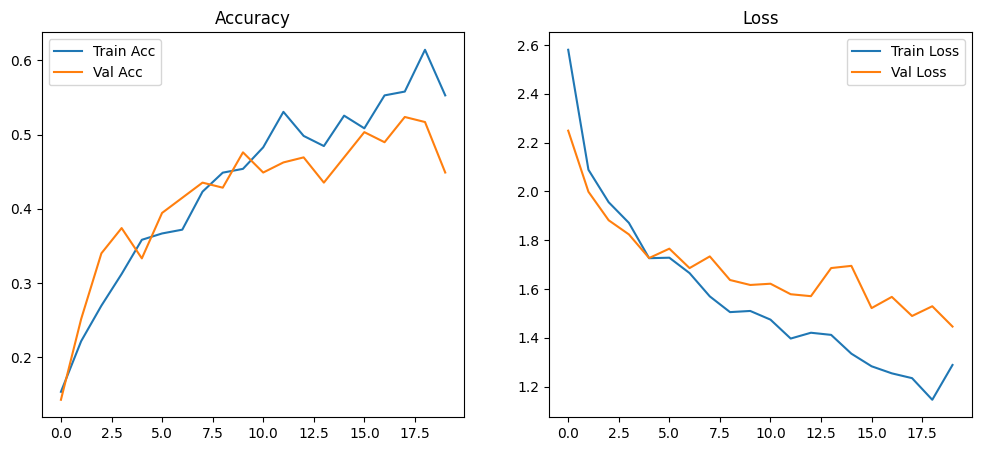

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label = 'Train Acc')
plt.plot(val_acc, label = 'Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


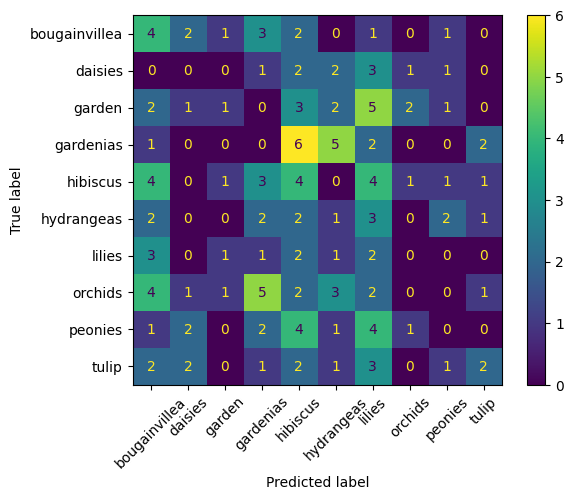

In [16]:
Y_pred = model.predict(testData_General)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(testData_General.classes, y_pred)
labels = list(testData_General.class_indices.keys())

ConfusionMatrixDisplay(cm, display_labels=labels).plot(xticks_rotation=45, cmap='viridis')

In [13]:
loss, acc = model.evaluate(testData_General)
print(f"Test Accuracy: {acc*100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4448 - loss: 1.4778
Test Accuracy: 44.90%


We can see from the chart on the left that our training and validation accuracy are mostly on an upwards trend throughout the epochs. The loss chart on the right tells us that our training and validation loss are on a downwards trend. Both of these things are relatively good news. However, the overall accuracy of the model is still kind of unreliable at 44.9% accuracy. The confusion matrix plot also reaffirms to us that the model doesn't do that great of a job. This could possibly be because our image dataset is relatively small (~700 images), so there isn't enough data for the model to be observant of details in the flower images.

In the future, I would hope to use a larger dataset to reduce bias and better train my model. I would also like to experiment with different types of models and pair the dropout method with something like batch normalization.